In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import tqdm
import numpy as np

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2023-11-01 12:36:35.514080: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-01 12:36:35.542748: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-01 12:36:35.669750: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-01 12:36:35.669775: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-01 12:36:35.670541: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(
    path='mnist.npz'
)
batch_size  = 128

In [3]:
from models import MnistGenerator, MnistDiscriminator
from wgan import WGAN
generator = MnistGenerator()
discriminator = MnistDiscriminator()
gan = WGAN(generator, discriminator)

In [4]:
ds = tf.data.Dataset.from_tensor_slices(x_train).map(lambda x:tf.cast(x[..., tf.newaxis], tf.float32)/255.0).cache().shuffle(x_train.shape[0]).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [5]:
generator_losses = []
discriminator_losses = []

In [29]:
progress_bar = tqdm.trange(100000)
for iteration in progress_bar:
    for real_data in ds.take(5):
        discriminator_loss = gan.discriminator_train_step(real_data)
        discriminator_losses.append(discriminator_loss)
    
    generator_loss = gan.generator_train_step(batch_size)
    generator_losses.append(generator_loss)    
    
    desc = f'generator loss: {np.mean(generator_losses[-100:]):05f} discriminator loss: {np.mean(discriminator_losses[-100:]):05f}'
    progress_bar.set_description(desc)

  0%|          | 0/100000 [00:00<?, ?it/s]

generator loss: 3.687213 discriminator loss: -2.060548: 100%|██████████| 100000/100000 [7:38:41<00:00,  3.63it/s] 


In [32]:
pred = gan.generator(tf.random.normal([10, 128]))

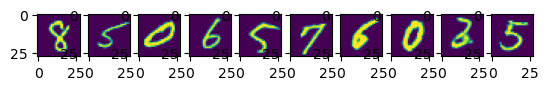

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10)
for i in range(10):
    ax[i].imshow(pred[i], vmin=0, vmax=1)

In [16]:
tf.math.reduce_min(pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

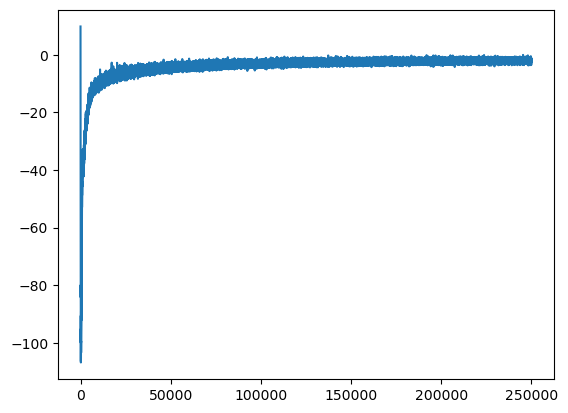

In [22]:
plt.plot(discriminator_losses)

In [37]:
gan.generator.save_weights('saved_models/mnist/generator/')
gan.generator.save_weights('saved_models/mnist/discriminator/')